In [1]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'terrain-recognition:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3728690%2F6457377%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240503%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240503T150202Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D915a3cfd25aff4ab1aa2bad198f4c2909ec86508cf38a7a256f59b9d6fc82608d4bc9dbf0c4515a3ba2beaabbc0e9456759c3f414e2fd84cd1bdc070dbe39e1334aa29813d732dec16b4919f6281854674b6fd91a150ea80c3522b73337393cfd627409b1e30d507bf4f225b65d3db8803b8da4258df21f91d8e33f158b05f34b24db4aac9255ae1f0b3e3e457ad9a12774ab9b30c037062259118d0921790aba811af2709b000b89ea12caa9e37ecabf19bf1441e82e5ec187f15ce0f21ff2704ff175b56ff9924e5f8fe8a7cf4823ed862d75dcb2a2e89335ba14dfd805c673fb29c478bbfdc0d0494a7b968f51905fbb5290435541578b324a8ce2913f074'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'


!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3393467440 bytes downloaded
Downloaded and uncompressed: terrain-recognition
Data source import complete.


In [2]:
pip install imagehash


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import glob as gb
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import imagehash
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.applications import VGG16
from keras.applications import ResNet101
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

In [4]:
train_path = '/kaggle/input/terrain-recognition/Data Main/train'
test_path = '/kaggle/input/terrain-recognition/Data Main/test'


In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
size_images = 150
batch_size = 32

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode ='categorical'
)

Found 31571 images belonging to 4 classes.


In [8]:
labels_count = train_generator.classes

In [9]:
print(labels_count)


[0 0 0 ... 3 3 3]


<ipython-input-10-5cb8d2510efe>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


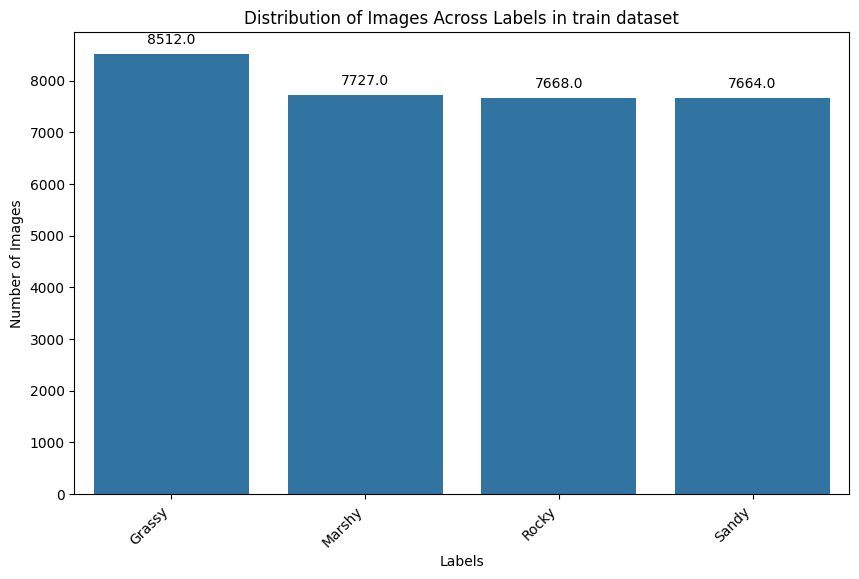

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
labels_count = train_generator.classes
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in train dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(class_names, rotation=45, ha='right')
plt.show()

In [11]:
test_datagen = ImageDataGenerator(rescale=1.0/255)


In [12]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

Found 6769 images belonging to 4 classes.


<ipython-input-13-15f5aa0577ff>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


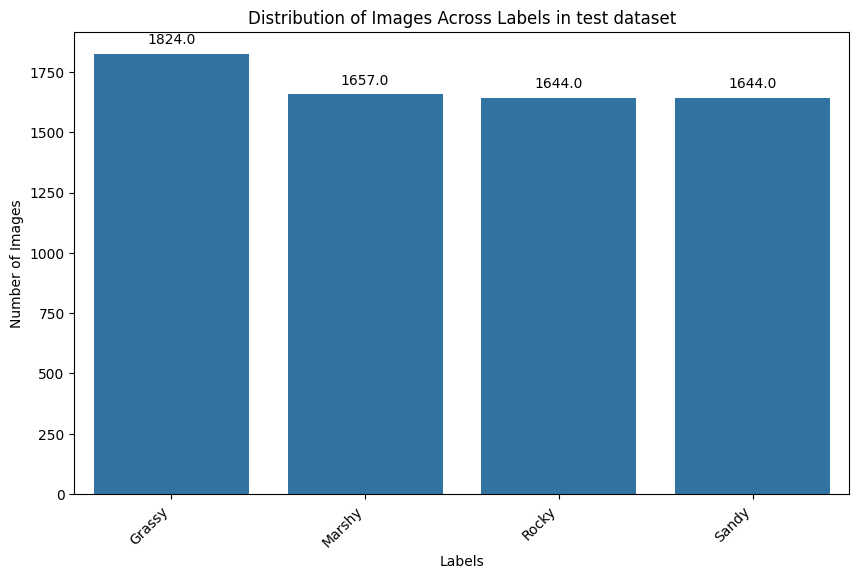

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
labels_count = test_generator.classes
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=labels_count)
plt.title('Distribution of Images Across Labels in test dataset')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
for i, p in enumerate(ax.patches):
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(class_names, rotation=45, ha='right')
plt.show()

In [14]:
def Show_Images(target_gen):
    batch_images, batch_labels = next(target_gen)
    class_labels = list(target_gen.class_indices.keys())
    plt.figure(figsize=(20, 20))
    for n , i in enumerate(list(np.random.randint(0,len(batch_images),36))):
        plt.subplot(6, 6, n + 1)
        plt.imshow(batch_images[i])
        plt.title(class_labels[np.argmax(batch_labels[i])])
        plt.axis('off')
    plt.show()

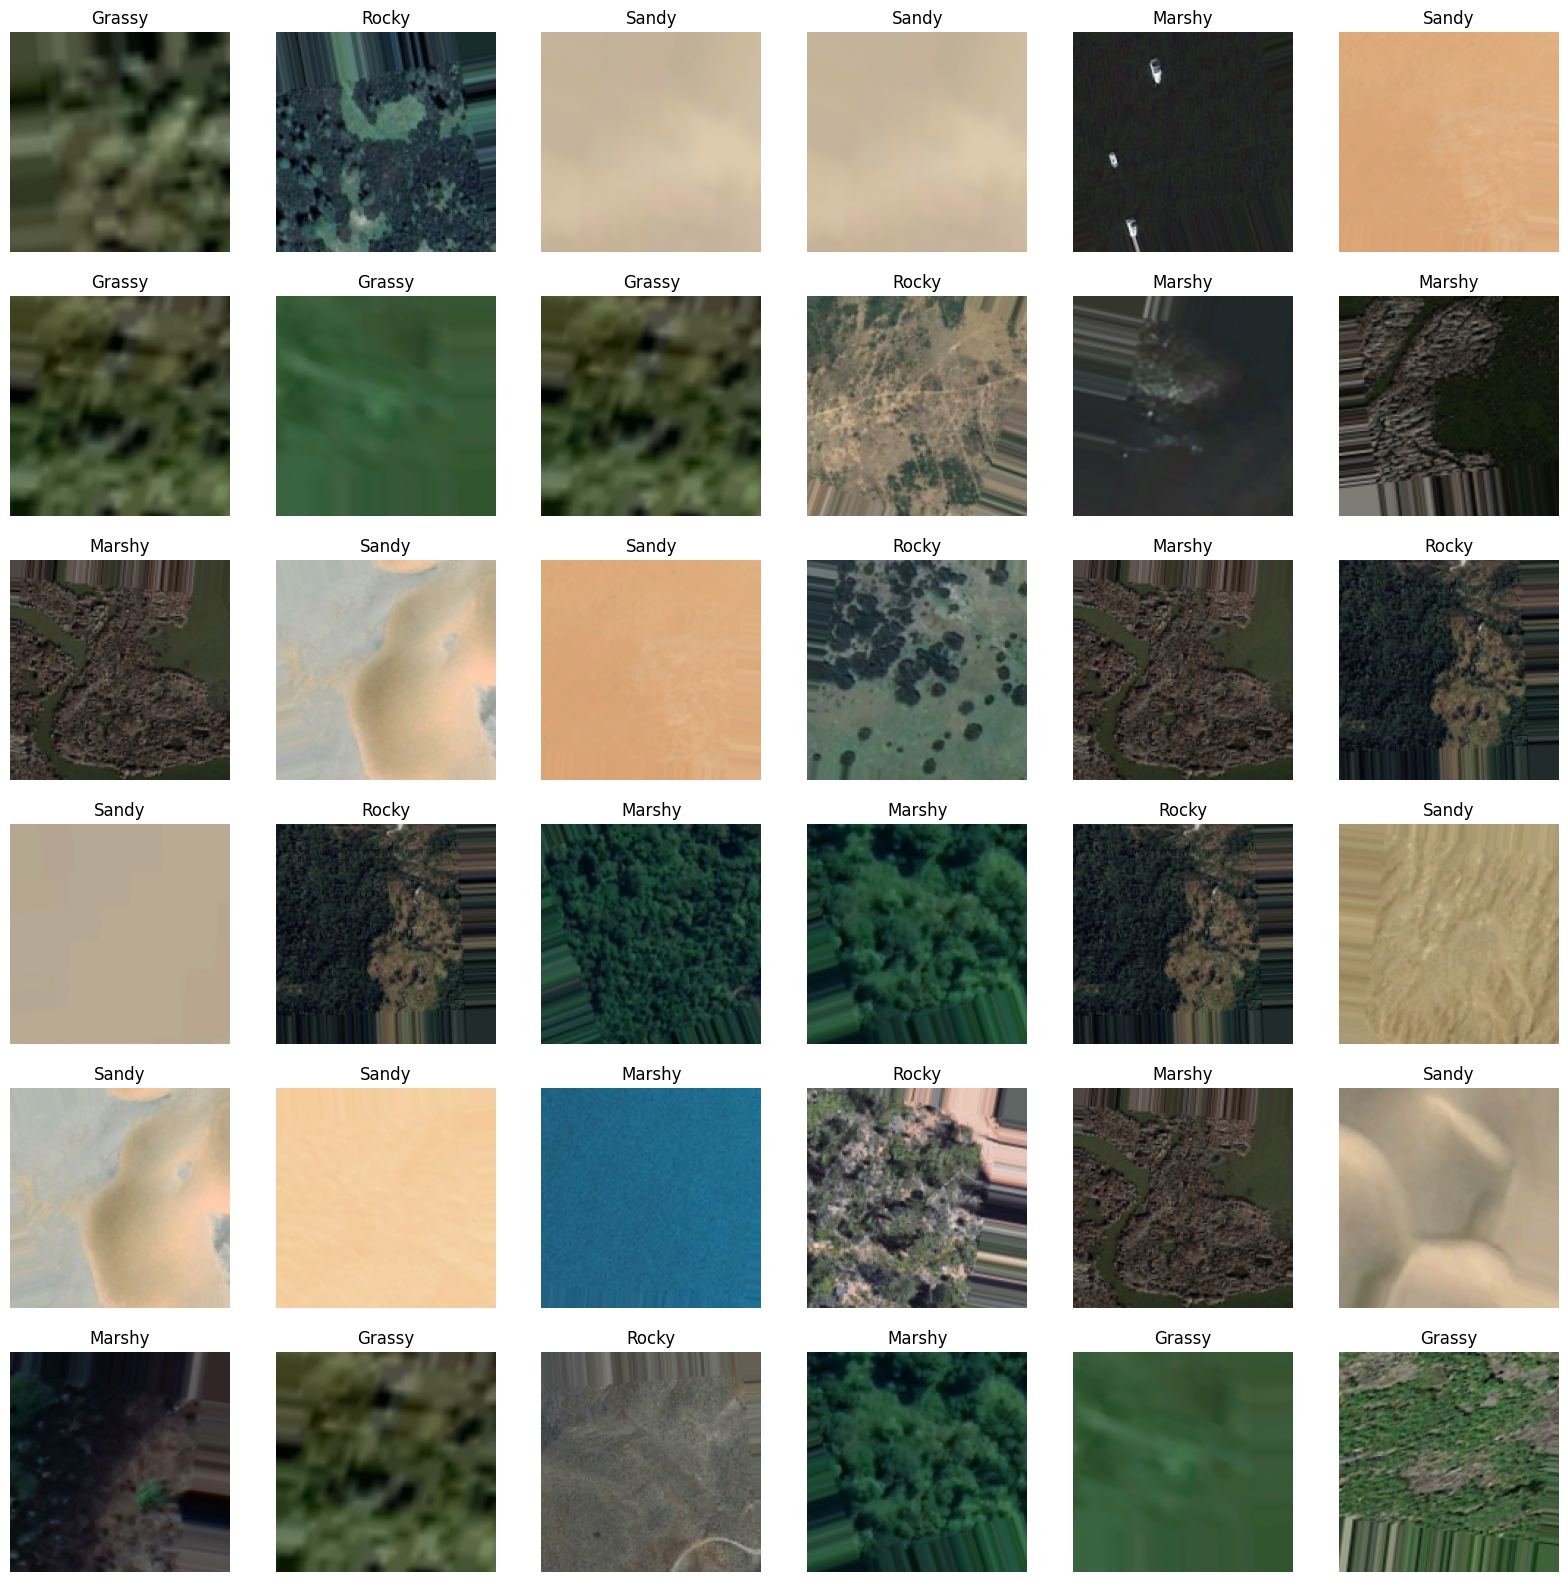

In [15]:
Show_Images(train_generator)

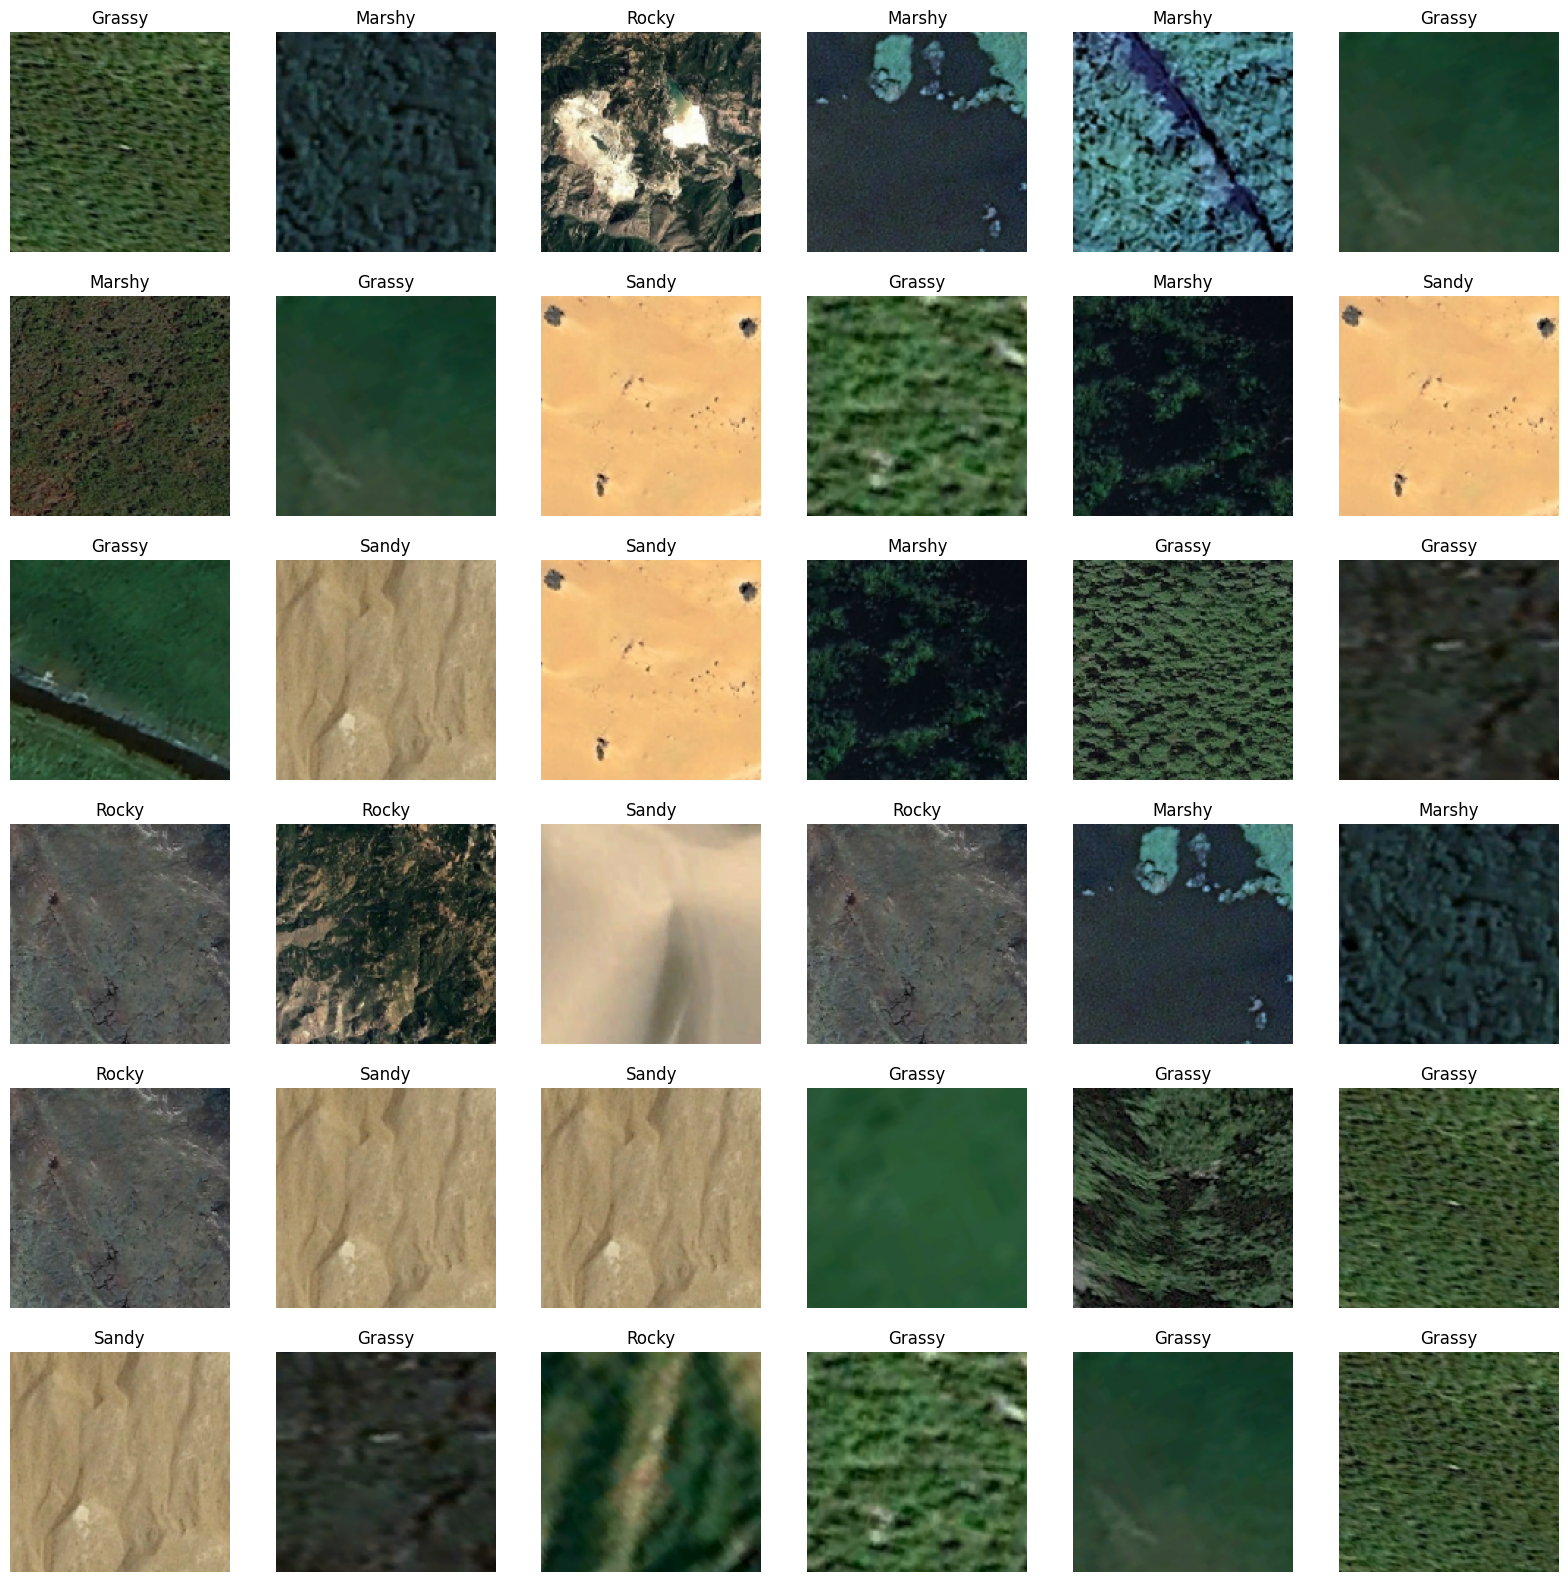

In [16]:
Show_Images(test_generator)

In [17]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

In [18]:
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [19]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(size_images, size_images, 3))

17225924/17225924 [==============================] - 0s 0us/step


In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
from tensorflow.keras import layers
model = tf.keras.models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6,activation='softmax'),
])

In [22]:

initial_learning_rate = 0.1
decay_steps = 1000
decay_rate = 0.5
staircase = True
def lr_schedule(epoch, lr):
    if staircase:
        return lr * decay_rate ** (epoch // decay_steps)
    else:
        return lr * decay_rate ** (epoch / decay_steps)

In [23]:

learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',
    patience=5,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [24]:
from keras.callbacks import LearningRateScheduler
lr_callback = LearningRateScheduler(lr_schedule)
callback=[early_stopping , learning_rate_reduce , lr_callback]

In [25]:
model.compile(optimizer=keras.optimizers.Adam(lr=lr_callback),
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [26]:
from tensorflow.keras.layers import Dense
model = tf.keras.Sequential(model.layers[:-1])
new_output = Dense(4, activation='softmax')
model.add(new_output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/15
986/986 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.8289

986/986 [==============================] - 966s 977ms/step - loss: 0.4778 - accuracy: 0.8289 - val_loss: 0.2687 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 2/15
986/986 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9045

986/986 [==============================] - 923s 936ms/step - loss: 0.2751 - accuracy: 0.9045 - val_loss: 0.2299 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 3/15
986/986 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9206

986/986 [==============================] - 938s 951ms/step - loss: 0.2283 - accuracy: 0.9206 - val_loss: 0.1875 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 4/15
986/986 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.9335

986/986 [==============================] - 953s 966ms/step - loss: 0.1978 - accuracy: 0.9335 - val_loss: 0.1527 - val_accuracy: 0.9418 - lr: 0.0010
Epoch 5/15
986/986 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9422

986/986 [==============================] - 961s 974ms/step - loss: 0.1782 - accuracy: 0.9422 - val_loss: 0.1668 - val_accuracy: 0.9351 - lr: 0.0010
Epoch 6/15
986/986 [==============================] - ETA: 0s - loss: 0.1593 - accuracy: 0.9453

986/986 [==============================] - 980s 994ms/step - loss: 0.1593 - accuracy: 0.9453 - val_loss: 0.1422 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 7/15
986/986 [==============================] - ETA: 0s - loss: 0.1504 - accuracy: 0.9499

986/986 [==============================] - 955s 969ms/step - loss: 0.1504 - accuracy: 0.9499 - val_loss: 0.1526 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 8/15
986/986 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9532

986/986 [==============================] - 961s 974ms/step - loss: 0.1449 - accuracy: 0.9532 - val_loss: 0.1220 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 9/15
986/986 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9569

986/986 [==============================] - 971s 984ms/step - loss: 0.1282 - accuracy: 0.9569 - val_loss: 0.1311 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 10/15
986/986 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9551

986/986 [==============================] - 954s 968ms/step - loss: 0.1365 - accuracy: 0.9551 - val_loss: 0.1128 - val_accuracy: 0.9615 - lr: 0.0010
Epoch 11/15
986/986 [==============================] - ETA: 0s - loss: 0.1175 - accuracy: 0.9608

986/986 [==============================] - 965s 979ms/step - loss: 0.1175 - accuracy: 0.9608 - val_loss: 0.1310 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 12/15
986/986 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9622

986/986 [==============================] - 956s 969ms/step - loss: 0.1146 - accuracy: 0.9622 - val_loss: 0.1287 - val_accuracy: 0.9559 - lr: 0.0010
Epoch 13/15
986/986 [==============================] - ETA: 0s - loss: 0.1117 - accuracy: 0.9655

986/986 [==============================] - 951s 965ms/step - loss: 0.1117 - accuracy: 0.9655 - val_loss: 0.1374 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 14/15
986/986 [==============================] - ETA: 0s - loss: 0.1040 - accuracy: 0.9659

986/986 [==============================] - 952s 965ms/step - loss: 0.1040 - accuracy: 0.9659 - val_loss: 0.1087 - val_accuracy: 0.9645 - lr: 0.0010
Epoch 15/15
986/986 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9650

986/986 [==============================] - 962s 975ms/step - loss: 0.1126 - accuracy: 0.9650 - val_loss: 0.1371 - val_accuracy: 0.9588 - lr: 0.0010


In [28]:
model.save('/kaggle/working/mohan.keras')

In [29]:
model.save('/usr/mymodel.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

212/212 [==============================] - 133s 624ms/step
Classification Report:
              precision    recall  f1-score   support

      Grassy       0.28      0.29      0.29      1824
      Marshy       0.25      0.25      0.25      1657
       Rocky       0.26      0.25      0.26      1644
       Sandy       0.25      0.25      0.25      1644

    accuracy                           0.26      6769
   macro avg       0.26      0.26      0.26      6769
weighted avg       0.26      0.26      0.26      6769



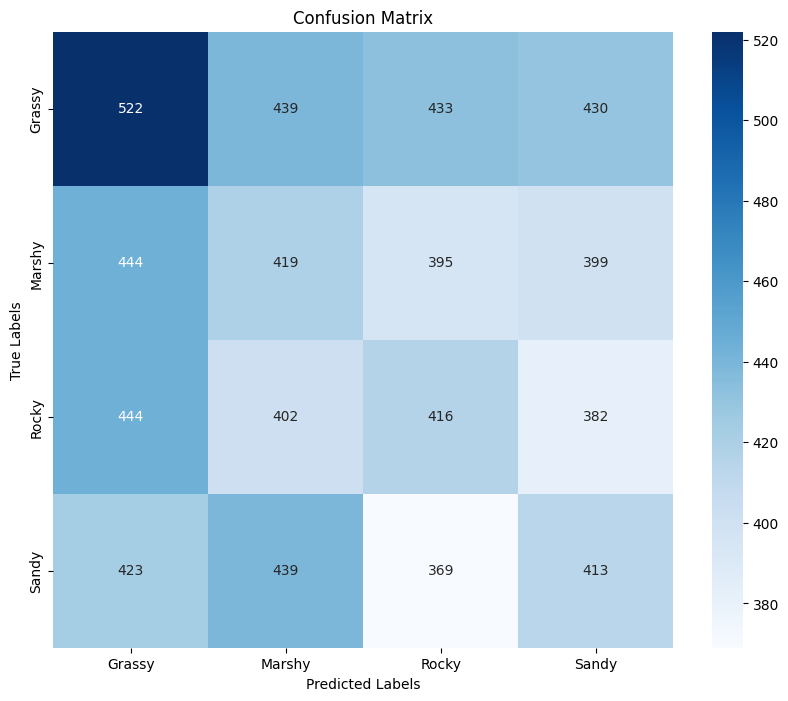

In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
loaded_model = load_model('/kaggle/working/mohan.keras')
predictions = loaded_model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [31]:
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13797718286514282
Test accuracy: 0.9584872126579285


<Figure size 640x480 with 0 Axes>

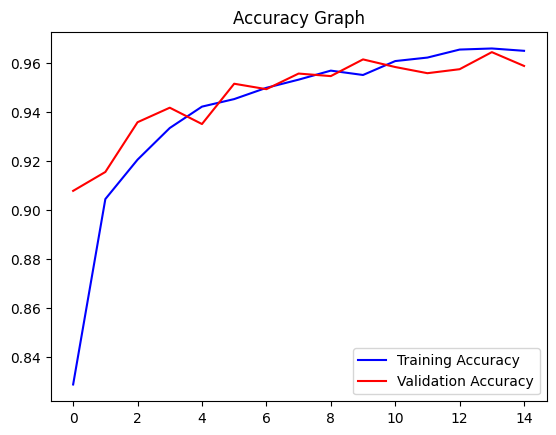

<Figure size 640x480 with 0 Axes>

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

In [33]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32) 

In [34]:


def predict_terrain(image_path):
  """
  Loads an image, preprocesses it, and predicts the terrain type using the trained model.

  Args:
      image_path: Path to the image file.

  Returns:
      predicted_terrain: The predicted terrain type based on the model's output.
  """

  img = cv2.imread(image_path)
  img = cv2.resize(img, (size_images, size_images))
  img = img.astype('float32') / 255.0
  img = np.expand_dims(img, axis=0)
  prediction = loaded_model.predict(img)
  predicted_class = np.argmax(prediction, axis=1)[0]
  terrain_labels = {0: "Grassy", 1: "Marshy", 2: "Rocky", 3: "Sandy"}
  predicted_terrain = terrain_labels[predicted_class]

  return predicted_terrain

image_path = input("Enter the path to your image: ")

predicted_terrain = predict_terrain(image_path)

print(f"Predicted Terrain: {predicted_terrain}")


Enter the path to your image: /Grassy (1)_13_9.png
1/1 [==============================] - 1s 565ms/step
Predicted Terrain: Grassy
